# DANA 4830 team project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import imread


from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn import metrics

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline

import os
import scipy.io

In [2]:
# fig configurations
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = [10,4]
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams.update({'legend.fontsize': 15})
plt.rcParams.update({'axes.labelsize': 25})
plt.rcParams.update({'font.size': 25})

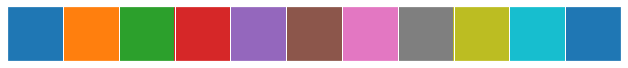

In [3]:
cpalette = sns.color_palette('tab10', 11)
sns.palplot(cpalette)

In [4]:
# savefig
def savePNG(f):
    fName = f+".png"
    fPath = os.path.join("figures",fName)
    plt.savefig(fPath, dpi=300)
    
# save df as csv
def saveCSV(f,fName):
    fName2 = fName+".csv"
    fPath = os.path.join("data",fName2)
    f.to_csv(fPath)

# 2020 data

In [5]:
d20 = pd.read_csv(os.path.join("data", "d20Master.csv"), index_col=0)

In [6]:
d20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108085 entries, 0 to 108084
Columns: 213 entries, AS to q64.13
dtypes: float64(213)
memory usage: 176.5 MB


In [7]:
key = list(d20.keys())

In [8]:
for j in d20.keys()[:4]:
    print("\n\nPercentage of categories for "+j+": \n", d20[j].value_counts()/d20.shape[0])



Percentage of categories for AS: 
 3.0    0.865856
2.0    0.092501
1.0    0.041643
Name: AS, dtype: float64


Percentage of categories for q1: 
 2.0    0.596697
1.0    0.368923
4.0    0.031790
3.0    0.002591
Name: q1, dtype: float64


Percentage of categories for q2@: 
 2.0    0.440773
1.0    0.384373
3.0    0.174853
Name: q2@, dtype: float64


Percentage of categories for q5@: 
 1.0    0.672554
2.0    0.303067
3.0    0.024379
Name: q5@, dtype: float64


## 2014  data

In [9]:
d14 = pd.read_csv(os.path.join("data", "d14Master.csv"), index_col=0)
d14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99392 entries, 0 to 99391
Columns: 208 entries, AS to q81g.1
dtypes: float64(208)
memory usage: 158.5 MB


In [10]:
for j in d14.keys()[:4]:
    print("\n\nPercentage of categories for "+j+": \n", d14[j].value_counts()/d14.shape[0])



Percentage of categories for AS: 
 3.0    0.874155
2.0    0.089383
1.0    0.036462
Name: AS, dtype: float64


Percentage of categories for q1: 
 2.0    0.575610
1.0    0.414571
3.0    0.009820
Name: q1, dtype: float64


Percentage of categories for q2@: 
 2.0    0.472402
1.0    0.381721
3.0    0.145877
Name: q2@, dtype: float64


Percentage of categories for q6@: 
 1.0    0.680990
2.0    0.297861
3.0    0.021149
Name: q6@, dtype: float64


# 2. Exploratory Factor Analysis

In [11]:
def split_sets(x, trainP=0.2, rs=42, stratified=False):
    testP = 1-trainP
    train_set, test_set = train_test_split(x, test_size=trainP, random_state=rs)
    return train_set, test_set

In [12]:
## alphabety
alphabet = list(map(chr, range(97, 123)))

In [13]:
def rm_cols(x, drp):
    drop_cols = []
    drp.append("nada")
    tick = [x.keys()[0], x.keys()[1], x.keys()[2], x.keys()[3]]
    tick_ix = [0, 1, 2, 3]

    for j in range(4, x.shape[1]):
        if x.keys()[j-1][:3] != x.keys()[j][:3]:
            tick.append(x.keys()[j])
            tick_ix.append(j)
    
    ix = dict(zip(tick, tick_ix))
    for k in range(len(drp)-1):
        i0 = ix[drp[k]]
        i1 = tick_ix[tick_ix.index(i0)+1]
        drop_cols += list(x[list(x.keys()[i0:i1].values)].keys())
        
    if ("q64.1" in drp) & ("q64.1" not in drop_cols):
        drop_cols += ["q64."+str(i) for i in range(1,14)]
        rm_ix = drp.index("q64.1")
        drp.pop(rm_ix)
        
    if ("q77" in drp) & ("q77" not in drop_cols):
        drop_cols += ["q77"]

    if ("q81a.1" in drp) & ("q81a.1" not in drop_cols):
        drop_cols += ["q81"+str(c)+".1" for c in list(map(chr, range(97, 104)))]

   
    return drop_cols

In [14]:
def feature_selector(X):
    feat = list((X.loadings[["Factor 1"]][X.loadings["Factor 1"] > 0.5]).index) + \
    [i for i in (X.loadings[["Factor 2"]][X.loadings["Factor 2"] > 0.5]).index if i not in (X.loadings[["Factor 1"]][X.loadings["Factor 1"] > 0.5]).index]
    return feat

In [75]:
## sub 2 : is the best cjoice for clustering Leadership styles in 2020
sub1 = rm_cols(d14, ["q19a", "q21a"])
sub2 = rm_cols(d20, ["q19a", "q21a"]) + ["q48e", "q47c"]

## compute new sets
X1 = d14[sub1]
X2 = d20[sub2] 

## 2.3 EFA

In [76]:
class ExpFacAn:

    def __init__(self, X, nFactors=5, rot=None):
        fa = FactorAnalyzer(n_factors=nFactors, rotation=rot)
        fa.fit(X)
        eigVal, Val = fa.get_eigenvalues()
        
        self.Fit = fa.fit(X)
        self.Eig = eigVal
        self.Val = Val
        
        '''
        Barlett specificity
        '''
        chi_square_value,p_value = calculate_bartlett_sphericity(X1)
        self.Barlett = (chi_square_value, p_value)

        '''
        Kaiser-Meyer_Olkin
        '''
        kmo_all, kmo_model = calculate_kmo(X1)
        self.KMO = kmo_model

        EFAloadings = pd.DataFrame(fa.loadings_, columns=["Factor "+str(i+1) for i in range(nFactors)])
        EFAloadings["q"] = list(X.keys())
        EFAloadings = EFAloadings.set_index("q")
        
        self.loadings = EFAloadings

% explained:  0.7794936980725443


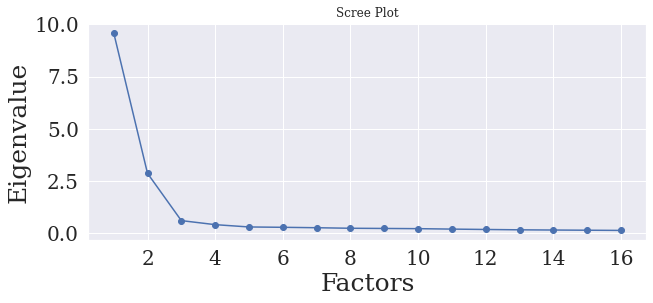

<Figure size 720x288 with 0 Axes>

In [77]:
## EFA for X2
efaX2 = ExpFacAn(X2, rot="varimax")

# pprint
print("% explained: ", np.cumsum(efaX2.Eig[:2])[-1]/sum(efaX2.Eig))

## plot
plt.scatter(range(1,X2.shape[1]+1),efaX2.Eig)
plt.plot(range(1,X2.shape[1]+1),efaX2.Eig)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

savePNG("Scree2020")

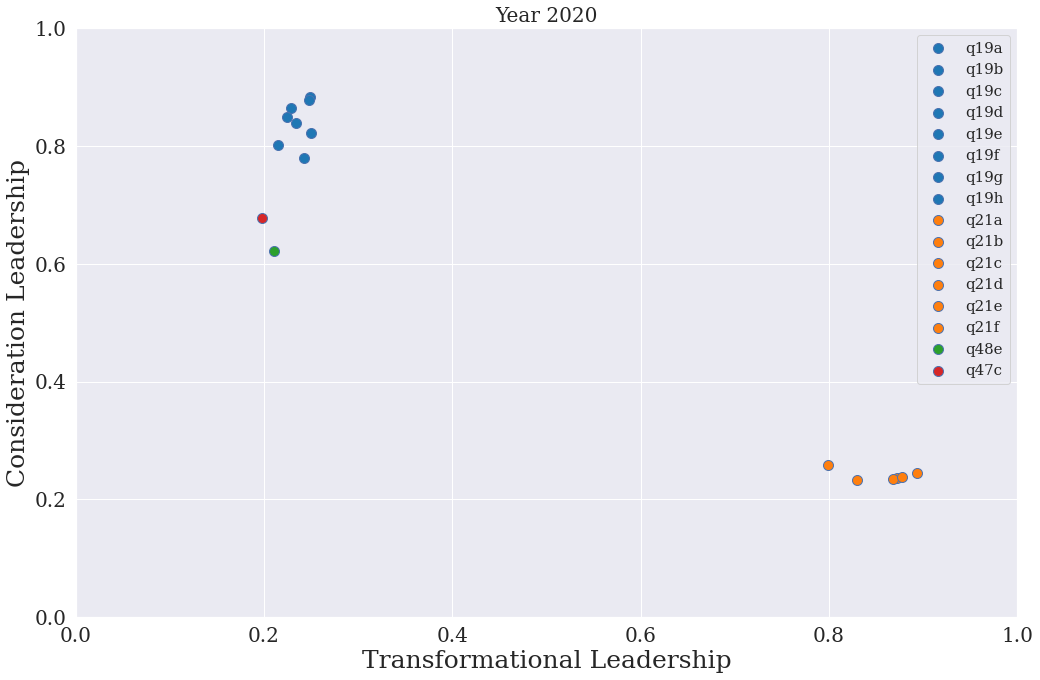

In [85]:
fig2 = plt.figure(figsize=(15,10))
axes = fig2.add_subplot(111)#, projection='3d')

ax_x = "Factor 1"
ax_y = "Factor 2"

color_i = 0


axes.scatter(efaX2.loadings[ax_y][0],efaX2.loadings[ax_x][0], marker='o', color=cpalette[color_i], s=100, edgecolor='b', label=efaX2.loadings.index[0])
for i in range(1, efaX2.loadings.shape[0]):
    x = efaX2.loadings[ax_y][i]
    y = efaX2.loadings[ax_x][i]
    #z = efaX1.loadings["Factor 3"][i]
    color_i = (color_i % (len(cpalette)-1))
    if efaX2.loadings.index[i-1][2] != efaX2.loadings.index[i][2]:
        color_i += 1
    #color_i += 1
    axes.scatter(x,y, marker='o', color=cpalette[color_i], s=100, edgecolor='b', label=efaX2.loadings.index[i])

    
axes.set_xlabel("Transformational Leadership")
axes.set_ylabel("Consideration Leadership")
axes.set_xlim(0,1)
axes.set_ylim(0,1)
#axes.set_zlabel("Factor 3")
axes.legend()

axes.set_title("Year 2020", size=20)
plt.tight_layout()



savePNG("FactorAnalysisLFI-2020")

In [19]:
## sub 2 : is the best cjoice for clustering Leadership styles in 2020
sub1 = rm_cols(d14, ["q20a", "q21a"]) + ["q18b"]
sub2 = rm_cols(d20, ["q19a", "q21a"]) + ["q48e", "q47c"]

## compute new sets
X1 = d14[sub1]
X2 = d20[sub2] 

/home/igodlab/anaconda3/envs/pytorch-env/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


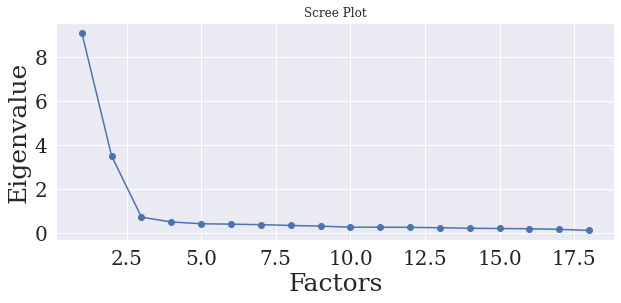

In [20]:
## EFA for X2
efaX1 = ExpFacAn(X1, rot="varimax")

## plot
plt.scatter(range(1,X1.shape[1]+1),efaX1.Eig)
plt.plot(range(1,X1.shape[1]+1),efaX1.Eig)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

% explained:  0.7023070433554797


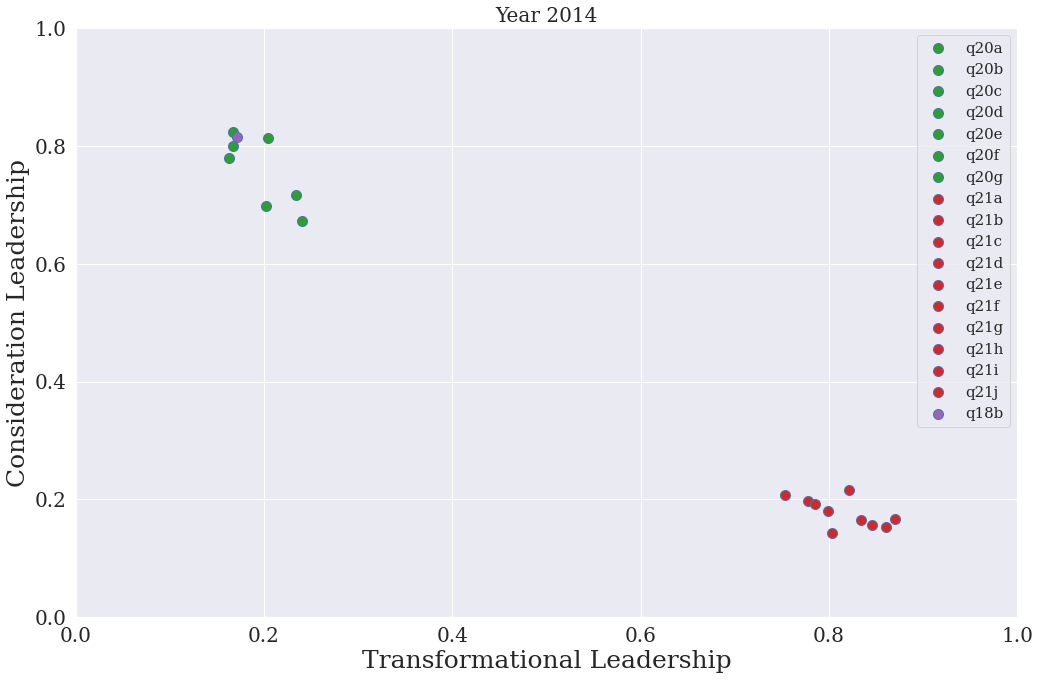

In [21]:
fig1 = plt.figure(figsize=(15,10))
axes = fig1.add_subplot(111)#, projection='3d')

ax_x = "Factor 1"
ax_y = "Factor 2"

color_i = 2


# pprint
print("% explained: ", np.cumsum(efaX1.Eig[:2])[-1]/sum(efaX1.Eig))

axes.scatter(efaX1.loadings[ax_x][0],efaX1.loadings[ax_y][0], marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX1.loadings.index[0])
for i in range(1, efaX1.loadings.shape[0]):
    x = efaX1.loadings[ax_x][i]
    y = efaX1.loadings[ax_y][i]
    #z = efaX1.loadings["Factor 3"][i]
    color_i = (color_i % (len(cpalette)-1))
    if efaX1.loadings.index[i-1][2] != efaX1.loadings.index[i][2]:
        color_i += 1
    #color_i += 1
    axes.scatter(x,y, marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX1.loadings.index[i])
    

#axes.scatter(efaX1.loadings[ax_x][1],efaX1.loadings[ax_y][1], marker='o', color=cpalette[4], s=50, label=efaX1.loadings.index[1])
axes.set_xlabel("Transformational Leadership")
axes.set_ylabel("Consideration Leadership")
axes.set_xlim(0,1)
axes.set_ylim(0,1)
#axes.set_zlabel("Factor 3")
axes.legend()

axes.set_title("Year 2014", size=20)
plt.tight_layout()

#savePNG("FactorAnalysisLFI-2014")

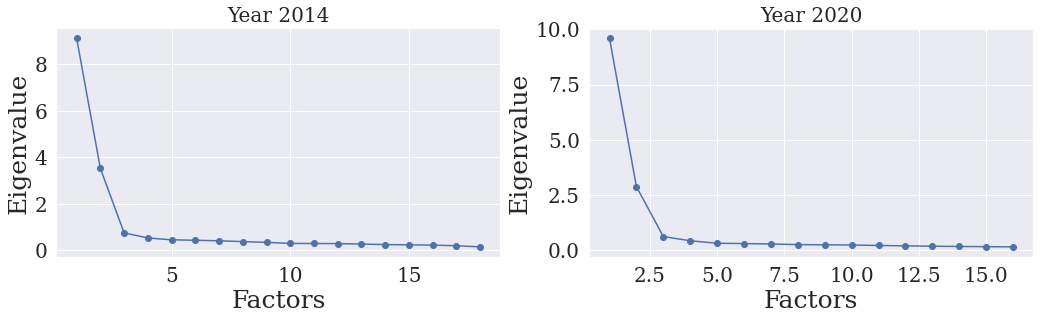

In [22]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

## plot
axes[0].scatter(range(1,X1.shape[1]+1),efaX1.Eig)
axes[0].plot(range(1,X1.shape[1]+1),efaX1.Eig)
axes[0].set_title('Year 2014', size=20)
axes[0].set_xlabel('Factors')
axes[0].set_ylabel('Eigenvalue')


## plot
axes[1].scatter(range(1,X2.shape[1]+1),efaX2.Eig)
axes[1].plot(range(1,X2.shape[1]+1),efaX2.Eig)
axes[1].set_title('Year 2020', size=20)
axes[1].set_xlabel('Factors')
axes[1].set_ylabel('Eigenvalue')

plt.tight_layout()
savePNG("scree-plots")

# Clustering analysis

In [23]:
from sklearn.cluster import KMeans

In [24]:
## function for metrics
def modelMetrics(model, X, Y):
    predict = model.predict(X)     ## predict outcomes using the test set
    probs   = model.predict_proba(X) ## generate class probabilities

    ## generate evaluation metrics
    jaccScore = metrics.accuracy_score(Y, predict)
    rocScore  = metrics.roc_auc_score(Y, probs[:, 1])

    conf_matrix = metrics.confusion_matrix(Y, predict)
    
    return {"jacc": jaccScore, "roc": rocScore, "confMat": conf_matrix}

In [62]:
#split
X1red = np.array(efaX1.loadings[["Factor 1", "Factor 2"]])
X2red = np.array(efaX2.loadings[["Factor 1", "Factor 2"]])

In [66]:
# k-Means algorithm
km = KMeans(n_clusters=2, random_state=42)

kmFit1 = km.fit_predict(X1red)
kmFit2 = km.fit_predict(X2red)

% 2014 explained:  0.7023070433554797
% 2020 explained:  0.7794936980725443


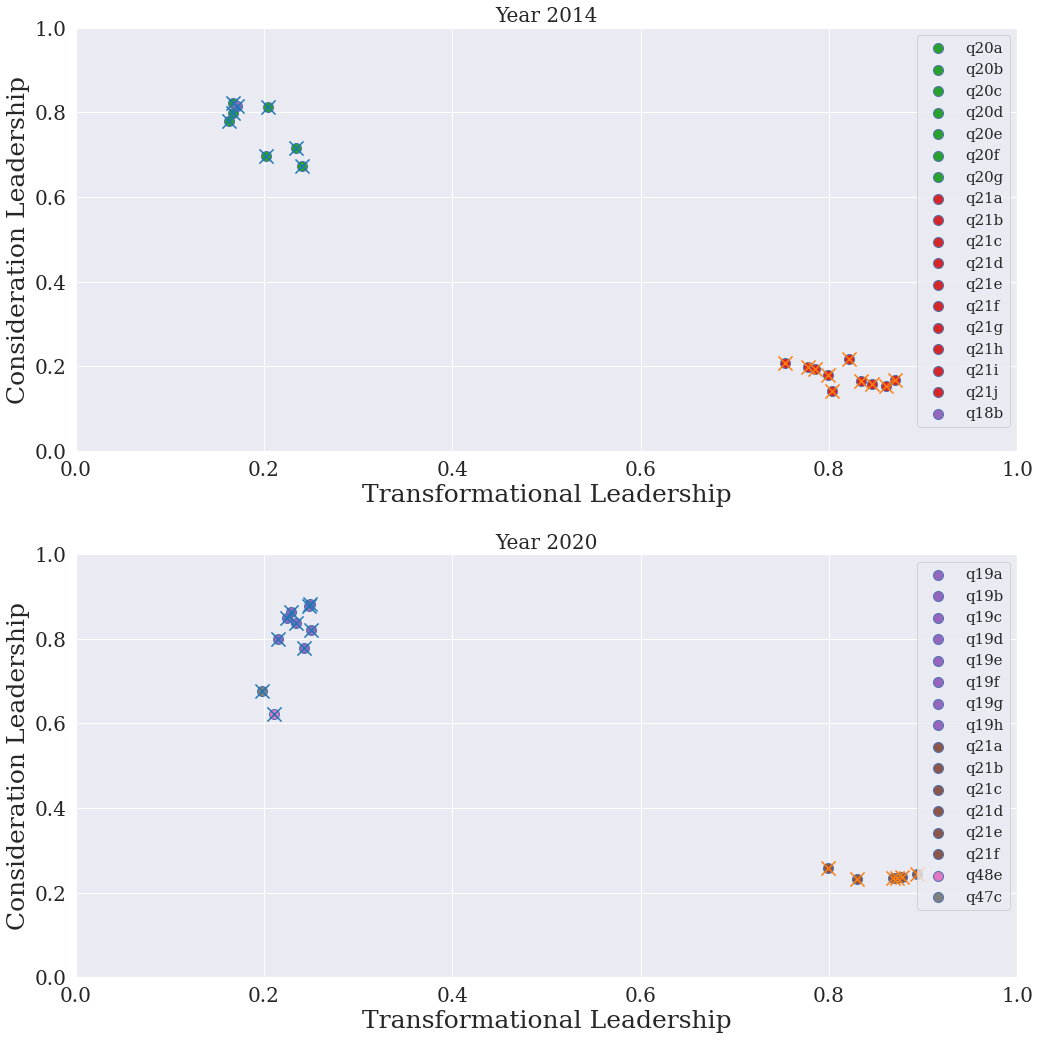

In [88]:
fig, axes = plt.subplots(2,1,figsize=(15,15))

ax_x = "Factor 1"
ax_y = "Factor 2"

color_i = 2

# 2014
# pprint
print("% 2014 explained: ", np.cumsum(efaX1.Eig[:2])[-1]/sum(efaX1.Eig))

axes[0].scatter(efaX1.loadings[ax_x][0],efaX1.loadings[ax_y][0], marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX1.loadings.index[0])
for i in range(1, efaX1.loadings.shape[0]):
    x = efaX1.loadings[ax_x][i]
    y = efaX1.loadings[ax_y][i]
    #z = efaX1.loadings["Factor 3"][i]
    color_i = (color_i % (len(cpalette)-1))
    if efaX1.loadings.index[i-1][2] != efaX1.loadings.index[i][2]:
        color_i += 1
    #color_i += 1
    axes[0].scatter(x,y, marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX1.loadings.index[i])
    

for i in range(efaX1.loadings.shape[0]):
    x = efaX1.loadings[ax_x][i]
    y = efaX1.loadings[ax_y][i]
    
    if kmFit1[i] == 0:
        axes[0].scatter(x,y,marker='x', color=cpalette[0], s=200)
    else:
        axes[0].scatter(x,y,marker='x', color=cpalette[1], s=200)


# 2020

# pprint
color_i = 4
print("% 2020 explained: ", np.cumsum(efaX2.Eig[:2])[-1]/sum(efaX2.Eig))

axes[1].scatter(efaX2.loadings[ax_y][0],efaX2.loadings[ax_x][0], marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX2.loadings.index[0])
for i in range(1, efaX2.loadings.shape[0]):
    x = efaX2.loadings[ax_y][i]
    y = efaX2.loadings[ax_x][i]
    #z = efaX1.loadings["Factor 3"][i]
    color_i = (color_i % (len(cpalette)-1))
    if efaX2.loadings.index[i-1][2] != efaX2.loadings.index[i][2]:
        color_i += 1
    #color_i += 1
    axes[1].scatter(x,y, marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX2.loadings.index[i])
    

for i in range(efaX2.loadings.shape[0]):
    x = efaX2.loadings[ax_y][i]
    y = efaX2.loadings[ax_x][i]
    
    if kmFit2[i] == 0:
        axes[1].scatter(x,y,marker='x', color=cpalette[0], s=200)
    else:
        axes[1].scatter(x,y,marker='x', color=cpalette[1], s=200)
    

axes[0].set_xlabel("Transformational Leadership")
axes[0].set_ylabel("Consideration Leadership")
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].legend()
axes[0].set_title("Year 2014", size=20)

axes[1].set_xlabel("Transformational Leadership")
axes[1].set_ylabel("Consideration Leadership")
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].legend()
axes[1].set_title("Year 2020", size=20)

plt.tight_layout()

#savePNG("FactorAnalysisLFI-2014")

In [93]:
print("2014 score: ",km.score(X1red))
print("2020 score: ",km.score(X2red))

2014 score:  -0.1647442046868483
2020 score:  -0.07814571689390136
